In [21]:
import networkx as nx
from cvrp_ortools_base import solve_cvrp
from collections import Counter


In [22]:
# Получить матрицу времени перемещений из графа для определенных узлов
def get_time_matrix(G_init):
    G_demand = G_init.copy()
    # Reindex nodes
    i = 0
    index_mapping = {}
    for node in G_demand.nodes:
        index_mapping[node] = i
        i += 1
    G = nx.relabel_nodes(G_demand, index_mapping, copy=False)
    max_index = i

    # Convert to time matrix
    time_matrix = []
    for i in range(max_index):
        l = []
        for j in range(max_index):
            if i == j:
                l.append(0)
            else:
                l.append(round(G[i][j]["weight"], 2))
        time_matrix.append(l)

    return time_matrix, index_mapping


In [23]:
# Получить массив спроса по узлам за период
def calc_demand(G_init, period: list, index_mapping):
    demand_dicts = []
    for date in period:
        demand_dict = nx.get_node_attributes(G_init, date)
        demand_dicts.append(demand_dict)
    # Суммировать спрос за период по каждому узлу
    accum_demand = Counter(demand_dicts[0])
    for i in range(1, len(demand_dicts)):
        accum_demand = accum_demand + Counter(demand_dicts[i])
    # Для использования в or-tools спрос должен быть представлен в виде массива, где узел идентифицируется индексом
    demand_list = list(accum_demand.values())
    # Включить узел депо с нулевым спросом
    start_node_index = index_mapping[start_node]
    demand_list.insert(start_node_index, 0)
    accum_demand[start_node] = 0
    return demand_list, accum_demand

In [138]:
# Граф Василеостровского района со значениями спроса по суткам
G_demand = nx.read_graphml('vrp_project/datasets/graph_with_demand.graphml')
dates = ['2023-03-01', '2023-03-02', '2023-03-03', '2023-03-04', '2023-03-05']
# Даты, за которые рассматривается спрос - считаем, что это прогнозные данные спроса
dates = ['2023-03-05']
# Ограничение количества узлов с потреблением для моделирования проблемы
# ЗДЕСЬ МОГУТ БЫТЬ ПЕРЕЧИСЛЕНЫ ТОЛЬКО УЗЛЫ СО СПРОСОМ
chosen_points = ['113', '47', '15', '87', '200', '16', '46', '63', '69', '83']
# Назначение узла-депо
start_node = '100'
# Задать доступное количество транспортных средств (фиксированное)
num_vehicles = 4
# Из графа исключаются все узлы, кроме выбранных узлов с потреблением и узла-депо
G_demand.remove_nodes_from(list(n for n in G_demand.nodes if n not in chosen_points and n != start_node))

# Получить матрицу времени перемещений для "обрезанного" графа
time_matrix, mapping = get_time_matrix(G_demand)
time_matrix = [[int(x) for x in row] for row in time_matrix]
# Получить индекс узла депо
depo_index = mapping[start_node]
# Для каждой даты решить задачу CVRP
total_time = 0
vehicles_by_date = {}
for date in dates:
    print(date)
    demand, demand_dict = calc_demand(G_demand, [date], mapping)
    print('Cпрос на дату: ', dict(demand_dict))
    print('')
    # Запустить решение CVRP при заданных параметрах
    vehicles_trips, covered_nodes, routing_time = solve_cvrp(time_matrix, demand, depo_index, num_vehicles, mapping)
    # Определить, сколько машин было задействовано
    vehicles = 0
    for k in vehicles_trips.keys():
        if vehicles_trips[k]>0:
            vehicles+=1
    vehicles_by_date[date] = vehicles
    # Накопить общее время машин в пути
    total_time += routing_time
    print('---------------------------------------------------------------------')
    print('')

print('Выезжало машин:')
print(vehicles_by_date)
print(f'Общее время в пути: {round(total_time/60,2)} час.')

2023-03-05
Cпрос на дату:  {'15': 267, '16': 417, '46': 63, '47': 959, '63': 1350, '69': 601, '83': 808, '87': 829, '113': 831, '200': 725, '100': 0}

Route for vehicle 0:
Node '100' Delivered(0) -> Node '87' Delivered(829) -> Node '83' Delivered(1637) -> Node '15' Delivered(1904) ->  Node '100' Delivered(1904)
Time of the route: 169min
Load of the route: 1904

Route for vehicle 1:
Node '100' Delivered(0) -> Node '200' Delivered(725) -> Node '113' Delivered(1556) -> Node '16' Delivered(1973) ->  Node '100' Delivered(1973)
Time of the route: 164min
Load of the route: 1973

Route for vehicle 2:
Node '100' Delivered(0) -> Node '69' Delivered(601) -> Node '47' Delivered(1560) -> Node '46' Delivered(1623) ->  Node '100' Delivered(1623)
Time of the route: 103min
Load of the route: 1623

Route for vehicle 3:
Node '100' Delivered(0) -> Node '63' Delivered(1350) ->  Node '100' Delivered(1350)
Time of the route: 20min
Load of the route: 1350

Total time of all routes: 456min
Total load of all ro

## GNN

In [62]:
import torch
import os
import numpy as np
from torch_geometric.data import Data, DataLoader
from VRP.creat_vrp import reward1,creat_instance
from VRP.VRP_Actor import Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from matplotlib import pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

In [112]:
def discrete_cmap(N, base_cmap=None):
    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

def plot_vehicle_routes(data, route, ax1, markersize=5, visualize_demands=False, demand_scale=1, round_demand=False):

    plt.rc('font', family='Times New Roman', size=10)

    routes = [r[r != 0] for r in np.split(route.cpu().numpy(), np.where(route.cpu().numpy() == 0)[0]) if (r != 0).any()]
    print(routes)
    depot = data.x[0].cpu().numpy()
    locs = data.x[1:].cpu().numpy()
    demands = data.demand.cpu().numpy()
    demands=demands[1:]

    capacity = data.capcity

    x_dep, y_dep = depot
    ax1.plot(x_dep, y_dep, 'sk', markersize=markersize * 4)
    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 1)

    legend = ax1.legend(loc='upper center')

    cmap = discrete_cmap(len(routes) + 2, 'nipy_spectral')
    dem_rects = []
    used_rects = []
    cap_rects = []
    qvs = []
    total_dist = 0
    for veh_number, r in enumerate(routes):
        color = cmap(len(routes) - veh_number)  # Invert to have in rainbow order

        route_demands = demands[r - 1]
        coords = locs[r - 1, :]
        xs, ys = coords.transpose()

        total_route_demand = sum(route_demands)
        #assert total_route_demand <= capacity
        if not visualize_demands:
            ax1.plot(xs, ys, 'o', mfc=color, markersize=markersize, markeredgewidth=0.0)

        dist = 0
        x_prev, y_prev = x_dep, y_dep
        cum_demand = 0
        for (x, y), d in zip(coords, route_demands):
            dist += np.sqrt((x - x_prev) ** 2 + (y - y_prev) ** 2)
            cap_rects.append(Rectangle((x, y), 0.01, 0.1))
            used_rects.append(Rectangle((x, y), 0.01, 0.1 * total_route_demand / capacity))
            dem_rects.append(Rectangle((x, y + 0.1 * cum_demand / capacity), 0.01, 0.1 * d / capacity))

            x_prev, y_prev = x, y
            cum_demand += d

        dist += np.sqrt((x_dep - x_prev) ** 2 + (y_dep - y_prev) ** 2)
        total_dist += dist
        qv = ax1.quiver(
            xs[:-1],
            ys[:-1],
            xs[1:] - xs[:-1],
            ys[1:] - ys[:-1],
            scale_units='xy',
            angles='xy',
            scale=1,
            color=color,
            label='R{}, N({}), C {} / {}, D {:.2f}'.format(
                veh_number,
                len(r),
                int(total_route_demand) if round_demand else total_route_demand,
                int(capacity) if round_demand else capacity,
                dist
            )
        )

        qvs.append(qv)

    ax1.set_title('Sampling1280,{} routes, total distance {:.2f}'.format(len(routes), total_dist), family='Times New Roman',size=20)

    ax1.legend(handles=qvs)
    plt.legend(loc=1)
    pc_cap = PatchCollection(cap_rects, facecolor='whitesmoke', alpha=1.0, edgecolor='lightgray')
    pc_used = PatchCollection(used_rects, facecolor='lightgray', alpha=1.0, edgecolor='lightgray')
    pc_dem = PatchCollection(dem_rects, facecolor='black', alpha=1.0, edgecolor='black')

    if visualize_demands:
        ax1.add_collection(pc_cap)
        ax1.add_collection(pc_used)
        ax1.add_collection(pc_dem)
    plt.show()
    #plt.savefig("./temp{}.png".format(54), dpi=600, bbox_inches='tight')

In [151]:
datas = []
n_nodes = 11
node_ = np.loadtxt('VRP/test_data/vrp20_test_data.csv', dtype=float, delimiter=',')
# demand_=np.loadtxt('VRP/test_data/vrp20_demand.csv', dtype=float, delimiter=',')
# demand_=np.loadtxt('VRP/test_data/demand_10.csv', dtype=float, delimiter=';')
# capcity_=np.loadtxt('VRP/test_data/vrp20_capcity.csv', dtype=float, delimiter=',')

node_ = node_[:11]
demand_ = np.array([[0, 1350, 959, 831, 829, 808, 725, 601., 417, 267, 63]])
# demand_= demand_[:1]
# capcity_ =capcity_[:1]

capcity_ = np.array([2000.0]) #настройка вместимости транспорта
# node_,demand_=node_.reshape(-1,n_nodes,2),demand_.reshape(-1,n_nodes)
node_ = node_.reshape(-1, n_nodes, 2)
data_size = node_.shape[0]

# x=np.random.randint(1,data_size)
x=0 # выбираем набор данных

# # Calculate the distance matrix
# edges = np.zeros((n_nodes, n_nodes, 1))
# def c_dist(x1, x2):
#     return ((x1[0] - x2[0]) ** 2 + (x1[1] - x2[1]) ** 2) ** 0.5
# for i, (x1, y1) in enumerate(node_[x]):
#     for j, (x2, y2) in enumerate(node_[x]):
#         d = c_dist((x1, y1), (x2, y2))
#         edges[i][j][0] = d
# edges_ = edges.reshape(-1, 1)

np_matrix = np.asarray(time_matrix)
np_matrix = np_matrix.reshape(-1, 1)


edges_index = []
for i in range(n_nodes):
    for j in range(n_nodes):
        edges_index.append([i, j])
edges_index = torch.LongTensor(edges_index)
edges_index = edges_index.transpose(dim0=0, dim1=1)

datas = []
data = Data(x=torch.from_numpy(node_[x]).float(), edge_index=edges_index, 
            edge_attr=torch.from_numpy(np_matrix).float(),
            demand=torch.tensor(demand_[x]).unsqueeze(-1).float(),
            capcity=torch.tensor(capcity_[x]).unsqueeze(-1).float())
datas.append(data)

data_loder = DataLoader(datas, batch_size=1)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Problem:VRP11 / Average distance: 5.9346433
[array([ 4, 10,  5,  9]), array([7, 2, 8]), array([3, 6]), array([1])]


/var/folders/h8/0wmx2zx90bn60jw8zc1r4qjc0000gn/T/ipykernel_7034/530569351.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  base = plt.cm.get_cmap(base_cmap)
/var/folders/h8/0wmx2zx90bn60jw8zc1r4qjc0000gn/T/ipykernel_7034/530569351.py:71: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  int(total_route_demand) if round_demand else total_route_demand,


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (4,) + inhomogeneous part.

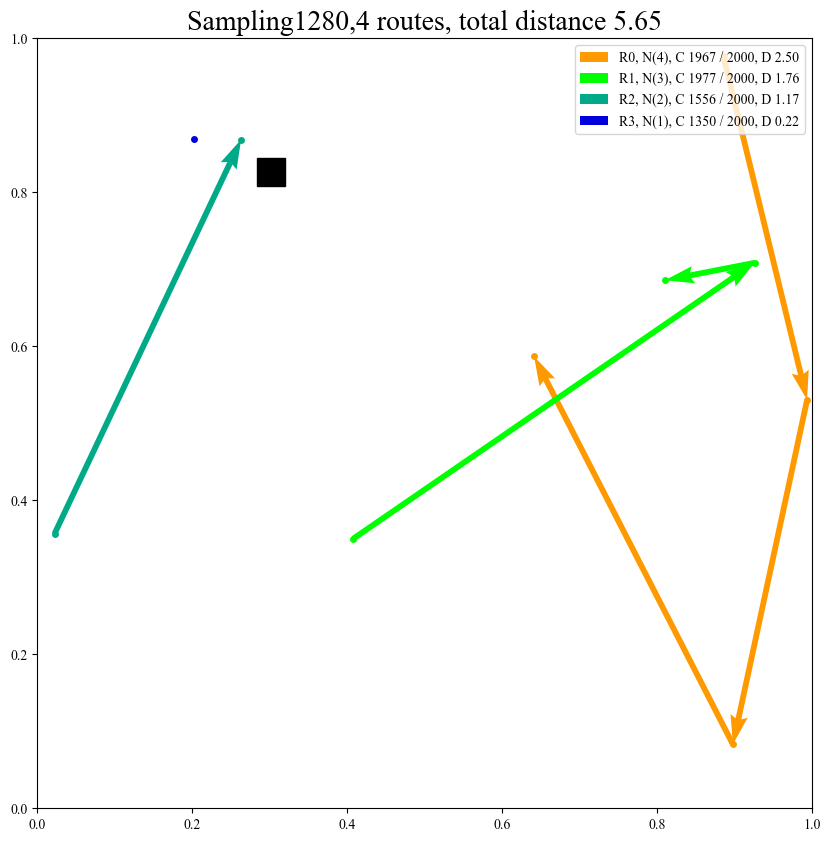

In [155]:
n_node = 11

agent = Model(3, 128, 1, 16, conv_laysers=4).to(device)
agent.to(device)
folder = 'trained'
filepath = os.path.join(folder, '%s' % n_nodes)
if os.path.exists(filepath):
        path1 = os.path.join(filepath, 'actor.pt')
        agent.load_state_dict(torch.load(path1, device))
datas_ = []
batch_size1 = 128  # sampling batch_size
for y in range(1280):
    data = Data(x=torch.from_numpy(node_[x]).float(), 
                edge_index=edges_index,
                edge_attr=torch.from_numpy(np_matrix).float(),
                demand=torch.tensor(demand_[x]).unsqueeze(-1).float(),
                capcity=torch.tensor(capcity_[x]).unsqueeze(-1).float())
    datas_.append(data)
dl = DataLoader(datas_, batch_size=batch_size1)

min_tour=[]
min_cost=100
T=1.2#Temperature hyperparameters
for batch in dl:
    with torch.no_grad():
        batch.to(device)
        tour1, _ = agent(batch, n_nodes * 2,False, T)
        cost = reward1(batch.x, tour1.detach(), n_nodes)
        id = np.array(cost.cpu()).argmin()
        m_cost=np.array(cost.cpu()).min()
        tour1=tour1.reshape(batch_size1,-1)
        if m_cost<min_cost:
            min_cost=m_cost
            min_tour=tour1[id]

tour=min_tour.unsqueeze(-2)
print('Problem:VRP''%s' % n_node,'/ Average distance:', m_cost)
for i, (data, tour) in enumerate(zip(data_loder, tour)):
    fig, ax = plt.subplots(figsize=(10, 10))
    plot_vehicle_routes(data, tour, ax, visualize_demands=False, demand_scale=50, round_demand=True)